# Stima Rt e simulazioni

Rt italiano e regionale e simulazioni d'incidenza.

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

***

Il modello di simulazione dei nuovi casi può fallire nei seguenti casi:

- _Eventi o interventi atti a diminuire drasticamente il tasso di trasmissione_ (lockdown, zone rosse, rinforzo delle norme di igiene e sicurezza, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare inferiori al miglior scenario previsto.
- _Eventi o situazioni in grado di aumentare drasticamente il tasso di trasmissione_ (grandi assembramenti, netta riduzione della conformità alle norme di igiene e sicurezza, riapertura scuole e università, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare superiori al peggior scenario previsto.
- _Interventi atti ad aumentare il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare inferiore al miglior scenario previsto.
- _Decisioni atte a diminuire il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare superiore al peggior scenario previsto.

In ogni caso, l'osservazione di un numero di nuovi casi 

- **inferiori al miglior scenario previsto** è una buona indicazione della resa degli interventi di contenimento eventualmente attuati
- **superiori al peggior scenario previsto** è una buona indicazione del fallimento degli interventi di contenimento eventualmente attuati e/o una chiara indicazione a considerare un rinforzo degli interventi in atto o l'introduzione di interventi più efficaci

***

**NB**: gli $R_t$ stimati da EpiDataItalia possono differire da quelli dell'Istituto Superiore di Sanità (ISS) perchè
-  i dati utilizzati da ISS provengono dal flusso di Sorveglianza Integrata (per dettagli consultare [EpiCentro](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)), in continuo aggiornamento e consolidamento, mentre EpiDataItalia usa i dati comunicati giornalmente dal Ministero della Salute
-  ISS usa metodo *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) sui soli **casi sintomatici** trasmessi localmente (stimati con contact-tracing) e decurtando i casi verosimilmente importati mentre EpiDataItalia ha scelto di stimare sui casi totali (sintomatici e non-sintomatici) per assenza di sufficienti evidenze che i soggetti asintomatici non siano in grado di trasmettere l'infezione
- per riprodurre la stima di $R_t$ di ISS è possibile utilizzare i dati e lo script in linguaggio `R` forniti da EpiCentro a [questo indirizzo](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)

> Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

***

Modelli utilizzati:

- stima di Rt: 
    - Italia: Wallinga-Teunis (ref: [Wallinga-Teunis 2004](https://doi.org/10.1093/aje/kwh255)) implementato in Markov chain Monte Carlo in `JAGS`, soglia minima d'incidenca 50 casi
    - Italia regioni e province: modello Cori et al. implementato per simulazione JARE, Just Another Rt Estimate (vedi dettagli [JARE simulation](https://www.epidata.it/PDF/JARE_simulation.pdf) e [JARE Italy](https://www.epidata.it/PDF/JARE_Italy.pdf)); il vantaggio dell'implementazione per simulazione è una maggior robustezza alle basse incidenze
    - Nazioni e continenti: EpiEstim Cori et al. (ref: [Package ‘EpiEstim’](https://cran.r-project.org/web/packages/EpiEstim/EpiEstim.pdf), [Cori et al. 2013](https://academic.oup.com/aje/article/178/9/1505/89262)) implementato in `python`, finestra temporale 14 giorni

- simulazioni di incidenza:
    - Cori et al., implementato con Markov chain Monte Carlo in `JAGS`. Scenari con Rt stabile e incremento/decremento del 10% 

- Distribuzione di intervallo di generazione Cereda-Tirani et al. (ref: [Cereda-Tirani 2020](https://arxiv.org/abs/2003.09320v1))

# Metodi

Il metodo **Wallinga-Teunis** ([Wallinga-Teunis 2004](https://doi.org/10.1093/aje/kwh255)) si basa sull'assunzione che la probabilità $p(t,i)$ che i nuovi casi $I_t$ in $t$ siano stati contagiati dai casi I_{t-i} in $t-i$ è pari a

$$
p(t,i) = I_t \frac{w_{t-i}}{I_i}
$$

dove $w_{t-i}$ corrisponde a

$$
w_{t,i} = \frac{ I_i \gamma_{t-i} }{ \sum_{j=1}^{t-i} I_j \gamma_{t-j} }
$$

ovvero l'incidenza normalizzata osservata in $i$ ponderata sulla massa di probabilità in $t-j$ dell'intervallo seriale $\gamma$.

Il numero di riproduzione effettivo istantaneo in $t$ è pertanto pari alla somma delle probabilità in $t$

$$
R_t = \sum_{i=1}^{t-1} p(t,i)
$$

Per ulteriori dettagli si rimanda all'articolo di Wallinga e Teunis (ref: [Wallinga-Teunis 2004](https://doi.org/10.1093/aje/kwh255))

È qui implementato con Markov chain Monte Carlo in `JAGS`, distribuendo le incidenze osservate come variabili di Poisson

$$
I_t \sim \mathcal{P}(\lambda = I_t)
$$

L'implementazione con Markov chain Monte Carlo in `JAGS` permette di generare simulazioni di incidenza per i successivi 15 giorni, basando la simulazione sull'assunto che (cfr: [Cori et al.](https://doi.org/10.1093/aje/kwt133))

$$
I_t = \sum_{i=1}^{s} I_{t-s} R_{t-s} \gamma_{s}
$$

supponendo che, per i giorni successivi all'ultimo osservato, $R_t$

- resti costante all'ultimo $R_t$ stimato (mid scenario)
- incrementi del 10% rispetto all'ultimo stimato (high scenario)
- decrementi del 10% rispetto all'ultimo stimato (low scenario)

e distribuendolo normale positivo con deviazione standard 0.1

$$
R_t \sim \mathcal{N}^+( \mu=R_t , \sigma=0.1 )
$$

***

- Bettencourt et al.: bayesiano sequenziale, modificato da Systrom (ref: [Bettencourt-Ribeiro 2008](https://doi.org/10.1371/journal.pone.0002185) e [Systrom 2020](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/)), ha intervalli di credibilità (è bayesiano, quindi non si tratta di intervalli di confidenza) molto ampi; è necessario prima smussare i dati con media mobile con finestra ampia almeno il doppio della media dell’intervallo seriale quindi l’ultimo Rt calcolato è del giorno centrale della finestra usata per la media mobile; è dipendente dalla deviazione standard dei priors assegnati a $R_t$ dei giorni precedenti.
- Robert Koch Institute: si basa sull'idea che $R_t$ sia pari al rapporto tra la somma delle incidenze in finestre temporali separate (ref: [Heiden et al. 2020](https://doi.org/10.25646/6692.4)). Le finestra temporali devono essere ampie almeno tanto quanto la media dell’intervallo seriale, quindi l'ultimo Rt è dell'ultimo giorno del primo paio di finestre temporali
- EpiEstim: si fonda sull'assuzione che $R_t$ sia distribuito Gamma con shape e rate pari rispettivamente alla somma delle incidenze in una finestra temporale e alle incidenze ponderate sulla massa di probabilità dell'intervallo seriale discretizzato nella medesima finestra (ref: [Cori et al. 2013](https://doi.org/10.1093/aje/kwt133)). La finestra di calcolo dev’essere ampia almeno quanto la media dell’intervallo seriale, quindi l’ultimo Rt è del primo giorno della finestra. Robusto anche con basse incidenze, utilizzato qui nella forma JARE EpiData-Pierini per simulazione [JARE simulation](https://www.epidata.it/PDF/JARE_simulation.pdf).
- Wallinga-Lipsitch: stima il coefficiente di crescita esponenziale intorno a due emi-finestre temporali (ref: [Wallinga-Lipsitch 2007](https://doi.org/10.1098/rspb.2006.3754)). Devono essere ampie almeno quanto la media dell’intervallo seriale. L’ultimo Rt è quello del giorno centrale alle due emi-finestre
- Wallinga-Teunis: non usa finestre temporali, quindi l’ultimo Rt è quello dell'ultimo giorno (ref: [Wallinga-Teunis 2004](https://doi.org/10.1093/aje/kwh255)) ma è corretto per con la probabilità cumulativa dell'intervallo seriale, quindi Rt degli ultimi giorni è meno affidabile. Poco robusto con basse incidenze.
- Wallinga-Teunis mod. Pierini EpiData.it: è sovrapponibile al Wallinga-Teunis ma con distribuzione delle osservazioni come variabili di Poisson in Markov chain Monte Carlo; ha intervalli di credibilità più ristretti. È qui utilizzato per l'Italia al fine di ottenere delle simulazioni d'incidenza basate sull'ultimo Rt

In [1]:
import datetime as dt
import json

import pickle
import numpy as np
import pandas as pd
import scipy.stats as sps
import pyjags
import arviz as az
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import Markdown
sns.set()
sns.set_palette('colorblind')

Si presenta di seguito un confronto tra le stime di $R_t$ con i metodi elencati. L'implementazione in `python` è visualizzabile sul repository GitHub del sito EpiData.it

In [2]:
ISS_sh = 1.87
ISS_ra = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def generation_time_gamma(sh, ra, plot=True, title='Estimated', size=None):

    dist = sps.gamma(a=sh, scale=1/ra)

    if size == None:
        max_x = int(np.ceil(dist.ppf(.9999)))
    else:
        max_x = size
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

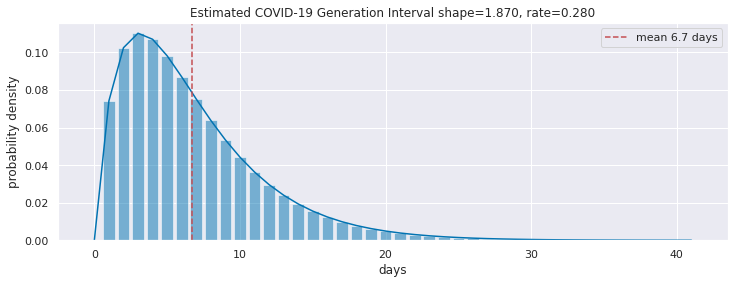

In [3]:
_, GT_y, _, _ = generation_time_gamma(ISS_sh, ISS_ra)

In [4]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'totale_casi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()
it.index = it.index.normalize()

In [5]:
SI_x, SI_y, SI_mu, SI_sd = generation_time_gamma(ISS_sh, ISS_ra, size=it.index.size, plot=False)

In [6]:
def wallinga_teunis_Rt(df,
                       GT,
                       CI=.99,
                       n_t0=None,
                       imported=None,
                       nsim=1000,
                       correct=True,
                       plot=False,
                       title='RESULTS'):
    
    epid = df.values
    start = 0
# --------->    
    if epid[0] == 0:
        start = (epid>0).nonzero()[0][0] + 1
# --------->    
    epid = epid[start:]
    
    # define the confidence interval
    q1 = (1 - CI) / 2
    q2 = CI - q1
    
    #Beginning of estimation 
    Tmax = epid.size
    
    #At the same time, multiple simulation to estimate quantiles for R(t) values.
    #At each time unit 's', we count how many offspring come from each of [1:s] time unit 
    multinom_simu = np.zeros(shape=(Tmax, Tmax, nsim))
    
    #Unknown initial n0 is set to first recorded value
    if n_t0 is None:
        n_t0 = epid[0]
    
# --------->
    # TBD imported
# --------->
    
    #Matrix to store probabilities
    #P[i,j] the mean number of offspring at time j caused by infected at time i
    #p[i,j] is proba that a case i infected case j
    PI = np.zeros(shape=(Tmax, Tmax))
    pi = np.zeros(shape=(Tmax, Tmax))
    
    #Pad GI with 0s to allow for matrix multiplication
    GT_to_0 = Tmax - GT.size
    GI = np.concatenate((GT, np.repeat(0, GT_to_0)))
    GI /= np.sum(GI)
    assert GI.size == Tmax
    
    #If autonomous cases were incident on day s, we have to find how previous cases may have contributed to them
    for s in range(Tmax):

        #Skip 1st
        if s < 1:
            continue

        if epid[s] > 0:

            #weights for index case detected on day s
            c = np.concatenate((np.repeat(0, s), [1]))
            assert c.size == epid[:s+1].size
            weight_cases_for_s = (epid[:s+1] - c) * GI[:s+1][::-1]

            #normalization
            weight_cases_for_s /= weight_cases_for_s.sum()
# --------->            
            weight_cases_for_s[np.isnan(weight_cases_for_s)] = 0
# --------->
            #Likelihood of a infected at time s to have been caused by parent in [1:s]
            #prob.cases.for.s[i] is the expected number of offspring on day s from one individual on day i
            _den = (epid[:s+1] - c)
            _den[_den <= 0] =1e-16
            prob_cases_for_s = weight_cases_for_s * epid[s] / _den
            prob_cases_for_s[:-1][epid[:s]==0] = 0

            #Should not be required, but just in case
            #only 1 icident case on day s: can't be its own infector
            if epid[s] == 1:
                prob_cases_for_s[s] = 0

            #PI will store the average number of offspring coming from each time unit :
            #PI[i,j] is the mean number of offspring at time j caused by infected at time i
            PI[:s+1,s] = prob_cases_for_s

            #Probabilities (empirical) are obtained obtained from weight_cases_for_s
            pi[:s+1,s] = weight_cases_for_s

            #We generate a high number of simulations with the computed probabilities
            #to find out how many infection result from each time unit.
            #multinom.sim list is updated from previous value, so we don't have to sum all lists at the end
            multinom_matrix = np.random.multinomial(
                epid[s],
                pi[:s+1,s],
                size=nsim,
            ).transpose()
            multinom_simu[s,:s+1,:] = multinom_simu[s-1,:s+1,:] + multinom_matrix

        else:

            PI[:s+1,s] = 0
            pi[:s+1,s] = 0
            multinom_simu[s,:s+1,:] = multinom_simu[s-1,:s+1,:]

    #We now have enough data to compute R (from infection network PI)
    #along with its 5% and 95% quantiles (from multiple simulations and pi)
    R_WT = PI.sum(axis=1)    # Wallinga and Teunis definition
    #plt.plot(R_WT)
    #plt.show()
    _den = np.cumsum(GI)[::-1]
    _den[_den <= 0] = 1e-16
    R_corrected = R_WT / _den   # Corrected for real time
    #plt.plot(R_corrected)
    #plt.show()
    if np.isnan(R_corrected[Tmax-1]):
        R_corrected[Tmax-1] = 0
        
    #Simulated incidence at each time unit is the sum of all cases,
    #stored in the last element of multinom.sim list
    total_infected_by_time_unit_simu = multinom_simu[Tmax-1,:,:]
    _den = epid.reshape(-1, 1)
    _den[_den <= 0] = 1e-16
    R_simu = total_infected_by_time_unit_simu / _den
    _den = np.cumsum(GI)[::-1].reshape(-1, 1)
    _den[_den <= 0] = 1e-16
    R_simu_corrected = R_simu / _den # Corrected for real time
    R_simu_corrected[Tmax-1,:] = 0
    
    #Initiating quantile matrix
    quant_simu = np.zeros(shape=(Tmax, 2))
    quant_simu_corrected = np.zeros(shape=(Tmax, 2))
    
    #Quantile are computed with the nsim*length(incid) values of R(t)
    for s in range(Tmax):
        if epid[s] == 0:
            R_WT[s] = 0
            R_simu[s] = 0
            R_corrected[s] = 0
            R_simu_corrected[s] = 0

        quant_simu[s,:] = np.quantile(R_simu[s,:], [q1, q2])
        quant_simu_corrected[s,:] = np.quantile(R_simu_corrected[s,:], [q1, q2])
        
    # changed Tmax to end
    ##details<< CI is computed by multinomial simulations at each time step with the expected value of R.
    conf_int = pd.DataFrame(columns=['R', 'lower', 'upper'])
    
    if correct:
        conf_int.R = R_corrected
        conf_int.lower = quant_simu_corrected[:,0]
        conf_int.upper = quant_simu_corrected[:,1]
    else :
        conf_int.R = R_WT
        conf_int.lower = quant_simu[:,0]
        conf_int.upper = quant_simu[:,1]
        
    results = conf_int[:-1]
    results.index = df.index[start:-1]
    results.index.name = 'date'

    if plot:
        fig, ax = plt.subplots(figsize=(15, 7))
        results.plot(y='R', color='k', ax=ax)
        ax.fill_between(
            results.index,
            results.lower, results.upper,
            color='k', alpha=.2,
            label=f'C.I. {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ylim = ax.get_ylim()
        ax.set(
            ylim=(0, min(ylim[1], 12)),
            title=f'{title}: $R_t$ estimation with Wallinga-Teunis-Cauchemez method'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend()
        plt.show()
    
    return results, PI

In [7]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end, ignore_under=50):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        if incid_sum > ignore_under and t_end[t] > final_mean_si:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + np.sum(_lambda[t_start[t]:t_end[t]+1]))
        else:
            a_posterior[t] = 0.1
            b_posterior[t] = 1.0
    return a_posterior, b_posterior

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 ignore_under=50,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - .99) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    #SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_x = np.arange(0, incid.size, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_tot = SI_y / SI_y.sum()
    #SI_tot = SI_y[1:]
    # pad SI with zeros
    #SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2    # shape
    b_prior = (sd_prior ** 2) / mu_prior    # scale
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end,
        ignore_under=ignore_under)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    #offset_idx = int(np.floor(window/2))
    res_index = idx[:-window]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:
        fig, ax = plt.subplots(figsize=(12, 5))
        _ = res.plot(y='R', ax=ax, color='k')
        ax.fill_between(
            res_index,
            quantile_lo_posterior, quantile_hi_posterior,
            color='k', alpha=.2,
            label=f'CI {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ylim = ax.get_ylim()
        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method), window {window} days',
                  #f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days',
            ylim=(0, min(12, ylim[1])),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='lower left')
        plt.show()
    
    return res

In [8]:
def num_den_rki2(arr, g=4):
    
    num_sums = []
    den_sums = []

    T = len(arr)
    r = np.arange(2*g, T+1).astype(int)
    for t in r:
        
        i_num_min = t-g
        i_num_max = t
        num = arr[i_num_min:i_num_max]
        #num_sum = np.sum(num)
        num_sums.append(num)
        
        i_den_min = t-2*g
        i_den_max = t-g
        den = arr[i_den_min:i_den_max]
        #den_sum = np.sum(den)
        den_sums.append(den)
        
    return np.array(num_sums), np.array(den_sums)

def estimate_Rt_rki(df, column='nuovi_positivi', g=7, ci=.99, plot=False, plot_fit=False, name='ITALY'):

    y_true = np.array([])
    y_pred = np.array([])
    
    alpha = (1 - ci) / 2
    
    arr = df[column].values
    idx = df.index
    
    scores = {
        'SI': [],
        'Chi2': [],
    }
    
    if g < 3:
        g = 3
    Y, X = num_den_rki2(arr, g=g)

    Rt = {'Rt': [], 'lo': [], 'hi': [], 'simple Rt':[] }

    for x, y in zip(X, Y):
        df = pd.DataFrame({'x': x, 'y': y})
        model = sm.GLM.from_formula('y ~ x - 1', data=df)  #, family=sm.families.Gaussian())
        results = model.fit()
        Rt['Rt'].append(results.params.x)
        Rt['lo'].append(results.conf_int(alpha)[0].x)
        Rt['hi'].append(results.conf_int(alpha)[1].x)
        Rt['simple Rt'].append(np.sum(y)/np.sum(x))
        scores['Chi2'].append(results.pearson_chi2)
        scores['SI'].append(g)
        
        if plot_fit:
            y_true = np.concatenate((y_true, y))
            y_pre_ = results.predict(df['x'])
            y_pred = np.concatenate((y_pred, y_pre_))
        
    Rt_df = pd.DataFrame(Rt)
    len_idx = Rt_df.index.size
    end_idx = g + len_idx
    #print(start_idx, end_idx, len_idx)
    Rt_df['data'] = idx[g:end_idx]
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 5))

        Rt_df.plot(x='data', y='Rt', ax=ax, lw=2)

        ax.fill_between(
            Rt_df['data'].values,
            Rt_df['lo'], Rt_df['hi'],
            alpha=.2, color='b'
        )
        ax.axhline(1, ls='--', color='k')
        ax.set(
            xlim=(idx[0], idx[-1]),
            title=fr'{name} $R_t$ estimation, RKI method, $\tau = {g}$ (CI: {ci:.0%})'
        )
        plt.show()

    return Rt_df, pd.DataFrame(scores), y_true, y_pred

In [9]:
def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

defined_p = [.99, .5]

#np.seterr(all='ignore')

# We create an array for every possible value of Rt
R_T_MAX = 5
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, filter_win=7, filter_std=2, smooth_win=14, smooth_std=5):

    cases[cases < 0] = 0

    filtered_states, states_outliers = hampel_filter_pandas(cases, filter_win, filter_std)

    smoothed_states = filtered_states.rolling(smooth_win).mean().round()
    smoothed_states[smoothed_states < 0] = 0
    
    #idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed_states = smoothed_states.dropna()
    original = cases.loc[smoothed_states.index]
    
    min_idx = int(np.ceil(smooth_win/2)) - 1
    max_idx = cases.index.size - min_idx - 1
    smoothed_states.index = cases.index[min_idx:max_idx]
    
    return original, smoothed_states

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = np.array([]), np.array([])
    j = 0
    while not lows.size or not highs.size:
        lows, highs = (total_p > (p-j)).nonzero()
        j += .05
        if j > 1:
            break
    
    if not len(lows):
        print("no lo")
        print(pmf)
        print(total_p)
        lows = np.array([0])
    if not len(highs):
        print("no hi")
        highs = np.array([1])
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    try:
        low = pmf.index[lows[best]]
    except Exception as err:
        print(f"lo{p} ERROR: {err}")
        low = 0
    try:
        high = pmf.index[highs[best]]
    except Exception as err:
        print(f"hi{p} ERROR: {err}")
        high = 1
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)[0]
    return {'indexes':idx, 'mass':HDImass, 'height':HDIheight}


def HDI_of_grid_from_df(pmf, p):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([HDI_of_grid_from_df(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    res = HDI_of_grid(pmf, p)
    #print(res["indexes"])
    lo_idx = res["indexes"][0]
    hi_idx = res["indexes"][-1]
    
    lo = pmf.index[lo_idx]
    hi = pmf.index[hi_idx]
    
    return pd.Series([lo, hi],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


def HDIs(pmf, P=[.95, .5]):
    RES = []
    for p in P:
        res = HDI_of_grid_from_df(pmf, p=p)
        RES.append(res)
    return RES

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    likelihoods[likelihoods==0] = 1e-15
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        #p_err = np.seterr(all='raise')
        #try:
        #    log_likelihood += np.log(denominator)
        #except Exception as err:
        #    print(f"log err {err} (d={denominator})")
        #    log_likelihood += np.log(1+1e-10)
        #np.seterr(**p_err)
    
    return posteriors, log_likelihood

def get_BR_Rt(sr, sigma=.02):
    _, sr_smoothed = prepare_cases(sr.copy(deep=True))

    # Note that we're fixing sigma to a value just for the example
    posteriors, log_likelihood = get_posteriors(sr_smoothed, sigma=sigma)

    # Note that this takes a while to execute - it's not the most efficient algorithm
    #hdis = highest_density_interval(posteriors)
    HDIS = HDIs(posteriors, [.99])

    most_likely = posteriors.idxmax().rename('ML')

    Rt_BR = most_likely
    for hdis in HDIS:
        Rt_BR = pd.concat([Rt_BR, hdis], axis=1)
    return Rt_BR

In [10]:
def epidata_Rt(df, column,
               SI_sh, SI_ra, 
               hdi_prob=.99,
               seed=42, chains=4, adapt=10, warmup=20, sample=20,
               verbose=False
              ):

    dist = sps.gamma(a=SI_sh, scale=1/SI_ra)

    size = df.index.size
    SI_x = np.linspace(0, size, size)
    SI_y = dist.pdf(SI_x)
    SI_y /= SI_y.sum()
    SI_cdf = SI_y.cumsum()
    SI_cdf_rev = SI_cdf[::-1]
    
    wallingaString = """
    var weight_cases_for_s[T,T], prob_cases_for_s[T,T], weight_cases_norms[T,T];

    model {
        prob_cases_for_s[1,1] <- 0
        
        Y[1] ~ dpois( y[1] )
        for ( s in 2:T ) {
            Y[s] ~ dpois( y[s] )
            weight_cases_for_s[s,1:(s-1)] <- Y[1:(s-1)] * SI_pdf_rev[(T-(s-1)):(T-1)]
            weight_cases_norms[s,1:(s-1)] <- weight_cases_for_s[s,1:(s-1)] / sum( weight_cases_for_s[s,1:(s-1)] )
            prob_cases_for_s[s,1:(s-1)] <- weight_cases_norms[s,1:(s-1)] * Y[s] / Y[1:(s-1)]
        }
        R_raw[1] <- sum( prob_cases_for_s[1:T,1] )
        R_raw[2] <- sum( prob_cases_for_s[3:T,2] )
        for ( s in 3:(T-1) ) {
            R_raw[s] <- sum( prob_cases_for_s[(s+1):T,s] )
        }

        R[1:(T-1)] <- R_raw[1:(T-1)] / SI_cdf_rev[1:(T-1)]
    }
    """
    
    wallinga_model_data = {
        'y': it[column].values,
        'T': size,
        'SI_pdf_rev': SI_y[::-1],
        'SI_cdf_rev': SI_cdf_rev,
    }

    wallinga_jags_model = pyjags.Model(
        code=wallingaString, 
        data=wallinga_model_data,
        chains=chains, 
        adapt=adapt,
        progress_bar=verbose,
        init={'.RNG.name': "base::Wichmann-Hill", ".RNG.seed": seed}
    )

    wallinga_jags_posteriors = wallinga_jags_model.sample(
        warmup + sample, vars=['R']
    )
    
    R_data = az.from_pyjags(wallinga_jags_posteriors,
        warmup_iterations=warmup, save_warmup=False)

    R = az.summary(
        R_data, hdi_prob=hdi_prob,
        var_names='R', kind='stats')
    R.index = it.index[:-1]
    
    return R

In [11]:
def wallinga_lipsitch(df, column, 
                      SI_sh, SI_ra, 
                      ci=.99, half_window=8):

    half_window = 8
    window_size = half_window * 2 + 1
    columns = df.index.size - half_window * 2

    dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x = np.arange(0, columns, 1)
    SI_y = dist.pdf(SI_x)
    SI_y /= SI_y.sum()

    y_matrix = np.zeros(shape=(window_size, columns))
    R = np.zeros(columns)
    R_lo = np.zeros(columns)
    R_hi = np.zeros(columns)

    x_array = np.arange(0, window_size)
    w_array = np.arange(columns)

    idx = 0
    for center in range(df.index.size):
        _left = center - half_window
        _right = center + half_window + 1
        y_array = df.nuovi_positivi.values[_left:_right]
        if y_array.size != window_size:
            continue

        data_df = pd.DataFrame({'x': x_array, 'y': y_array})
        model = sm.GLM.from_formula('y ~ 1 + x', data=data_df, family=sm.families.Poisson())
        res = model.fit()
        _r = res.params.x
        _r_conf = res.conf_int(.01).transpose().x
        R[idx] = 1 / np.sum(SI_y * np.exp(-_r * w_array) )
        R_lo[idx] = 1 / np.sum(SI_y * np.exp(-_r_conf[0] * w_array) )
        R_hi[idx] = 1 / np.sum(SI_y * np.exp(-_r_conf[1] * w_array) )
        idx += 1
        
    R_df = pd.DataFrame({'R': R, 'lo': R_lo, 'hi': R_hi})
    R_df.index = df.index[half_window:-half_window]
    return R_df

In [12]:
def prepare_methods(_Rt_BR, _Rt_RK, _Rt_WT, _Rt_EE, _Rt_WL, _Rt_MP,
                   BR_time, RK_time, WT_time, EE_time, WL_time, MP_time):

    Rt_BR = _Rt_BR.copy(deep=True)
    Rt_RK = _Rt_RK.copy(deep=True)
    Rt_WT = _Rt_WT.copy(deep=True)
    Rt_EE = _Rt_EE.copy(deep=True)
    Rt_WL = _Rt_WL.copy(deep=True)
    Rt_MP = _Rt_MP.copy(deep=True)

    if Rt_BR is not None:
        Rt_BR.columns = ['R', 'lo', 'hi']

    if Rt_RK is not None:
        Rt_RK.set_index('data', inplace=True)
        Rt_RK.columns = ['R', 'lo', 'hi', 'simple Rt']

    if Rt_WT is not None:
        Rt_WT.columns = ['R', 'lo', 'hi']
        
    if Rt_WL is not None:
        Rt_WL.columns = ['R', 'lo', 'hi']

    if Rt_EE is not None:
        Rt_EE.drop('std', axis=1, inplace=True)
        Rt_EE.columns = ['R', 'lo', 'hi']
        
    if Rt_MP is not None:
        Rt_MP.drop('sd', axis=1, inplace=True)
        Rt_MP.columns = ['R', 'lo', 'hi']

    methods = {
        'Bettencourt-Ribeiro-Systrom': Rt_BR, 
        'Robert Koch Institute': Rt_RK, 
        'Wallinga-Teunis': Rt_WT, 
        'EpiEstim Cori et al.': Rt_EE,
        'Wallinga-Lipsitch': Rt_WL, 
        'Wallinga-Teunis-EpiData.it': Rt_MP,
    }
    times = {
        'Bettencourt-Ribeiro-Systrom': BR_time, 
        'Robert Koch Institute': RK_time, 
        'Wallinga-Teunis': WT_time, 
        'Wallinga-Lipsitch': WL_time, 
        'EpiEstim Cori et al.': EE_time,
        'Wallinga-Teunis-EpiData.it': MP_time,
    }
    
    return methods, times

In [13]:
def plot_compare_Rt(methods, times, zone='ITALIA', Rt=None, xlim=None):
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    gs = GridSpec(3, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    
    ax = [ax1, ax2, ax3, ax4, ax5, ax6]

    for i, method in enumerate(methods):
        
        _df = methods[method]
        _tm = times[method]
        try:
            mean_time = _tm.average
            sd_time = np.round(_tm.stdev, 3)
        except:
            mean_time = _tm.total_seconds()
            sd_time = None
        
        if _df is not None:
            _df.plot(y='R', ax=ax[i], label='Rt', color=f'C{i}', lw=2)
            ax[i].fill_between(
                _df.index,
                _df.lo, _df.hi,
                alpha=.2, color=f'C{i}',
                label='C.I. 99%'
            )
            esecuzione = f'esecuzione in {mean_time:.3f} sec'
            if sd_time is not None:
                esecuzione += f' (SD: {sd_time})'
            if mean_time is not None:
                ax[i].text(
                    .1, .9,
                     esecuzione,
                    transform=ax[i].transAxes
                )
                
            ax[i].set_title(f'Metodo {method}', fontsize=15)
            ax[i].legend()
            ax[i].axhline(1, color='k', ls='--', lw=1)
            ax[i].tick_params(axis='y', which='both', labelleft='on', labelright='on')
            ylim = ax[i].get_ylim()
            ax[i].set(
                xlim=xlim,
                ylim=(0, 4),
            )
        if Rt is not None:
            ax[i].plot(Rt, color='k', label='Real Rt')
            ax[i].legend()

    #Rt_BR.plot(y='R', ax=ax[-1], lw=2, ls=':',  label='Bettencourt-Ribeiro-Systrom')
    #Rt_RK.plot(y='R', ax=ax[-1], lw=2, ls='-.', label='Robert Koch Institute')
    #Rt_WT.plot(y='R', ax=ax[-1], lw=2, ls='-',  label='Wallinga-Teunis')
    #Rt_EE.plot(y='R', ax=ax[-1], lw=2, ls='--', label='EpiEstim Cori et al.')
    #ax[-1].set(
    #    xlim=xlim,
    #    ylim=(0, 4),
    #)
    #ax[-1].axhline(1, color='k', ls='--')
    #ax[-1].tick_params(axis='y', which='both', labelleft='on', labelright='on')
            
    fig.suptitle(f'{zone} COVID-19: confronto tra principali metodi di stima $R_t$ istantaneo', fontsize=20)
    #fig.tight_layout()
    #fig.set_facecolor('#00000000')
    #fig.savefig('comparazione-metodi.png', dpi=300)
    plt.show()

In [14]:
_it = it.copy(deep=True)

Rt_BR = None
Rt_RK = None
Rt_EE = None
Rt_WT = None
Rt_MP = None
Rt_WL = None

WT_time = None
BR_time = None
EE_time = None
RK_time = None
MP_time = None
WL_time = None

start = dt.datetime.now()
try:
    #EE_time = %timeit -n 2 -r 2 -o epi_estim_Rt(_it.nuovi_positivi, SI_sh=SI_ISS_sh, SI_ra=SI_ISS_ra)
    Rt_EE = epi_estim_Rt(_it.nuovi_positivi, SI_sh=ISS_sh, SI_ra=ISS_ra, window=7)
except Exception as err:
    print('EE', err)
    Rt_EE = None
EE_time = dt.datetime.now() - start

start = dt.datetime.now()
try:
    #WL_time = %timeit -n 2 -r 2 -o wallinga_lipsitch(_it, 'nuovi_positivi', SI_ISS_sh, SI_ISS_ra)
    Rt_WL = wallinga_lipsitch(_it, 'nuovi_positivi', ISS_sh, ISS_ra)
except Exception as err:
    print('WL', err)
    Rt_WL = None
WL_time = dt.datetime.now() - start

start = dt.datetime.now()
try:
    #WT_time = %timeit -n 2 -r 2 -o wallinga_teunis_Rt(_it.nuovi_positivi, GTy, plot=False)
    Rt_WT, _ = wallinga_teunis_Rt(_it.nuovi_positivi, GT_y, plot=False)
except Exception as err:
    print('WT', err)
    Rt_WT = None
WT_time = dt.datetime.now() - start

start = dt.datetime.now()
try:
    #RK_time = %timeit -n 2 -r 2 -o estimate_Rt_rki(_it, g=7)[0]
    Rt_RK = estimate_Rt_rki(_it, g=7)[0]
except Exception as err:
    print('RK', err)
    Rt_RK = None
RK_time = dt.datetime.now() - start

start = dt.datetime.now()
try:
    #BR_time = %timeit -n 2 -r 2 -o get_BR_Rt(_it.nuovi_positivi, sigma=.02)
    Rt_BR = get_BR_Rt(_it.nuovi_positivi, sigma=.02)
except Exception as err:
    print('BR', err)
    Rt_BR = None
BR_time = dt.datetime.now() - start
    
start = dt.datetime.now()
try:
    #MP_time = %timeit -n 2 -r 2 -o epidata_Rt(_it, 'nuovi_positivi', SI_ISS_sh, SI_ISS_ra)
    Rt_MP = epidata_Rt(_it, 'nuovi_positivi', ISS_sh, ISS_ra, verbose=False)
except Exception as err:
    print('MP', err)
    Rt_MP = None
MP_time = dt.datetime.now() - start

In [15]:
methods, times = prepare_methods(
    Rt_BR, Rt_RK, Rt_WT, Rt_EE, Rt_WL, Rt_MP,
    BR_time, RK_time, WT_time, EE_time, WL_time, MP_time
)

In [16]:
with open('Rt_estimates.pkl', 'wb') as f:
    pickle.dump(methods, f)

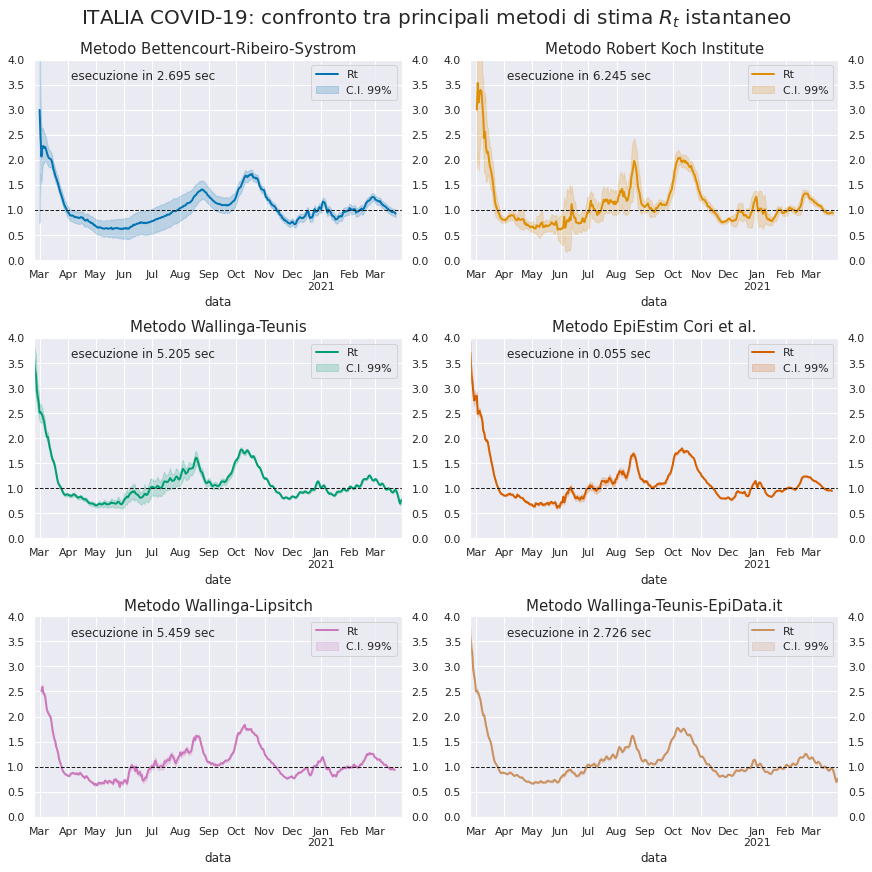

In [17]:
plot_compare_Rt(methods, times, zone='ITALIA', xlim=(it.index[0], it.index[-1]))

***

In [18]:
start = dt.datetime.now()

In [19]:
pieriniModelString = """
var weight_cases_for_s[T,T], prob_cases_for_s[T,T], weight_cases_norms[T,T];

model {
    unknown_Rt ~ dnorm( 0 , 1/(0.1)^2 ) T(0,)
    prob_cases_for_s[1,1] <- 0

    P[1] ~ dpois( y[1] )
    Y[1] <- ifelse( P[1] > 0 , P[1] , 1.0E-32 )
    y_pred_hi[1] <- Y[1]
    y_pred_mu[1] <- Y[1]
    y_pred_lo[1] <- Y[1]

    for ( s in 2:T ) {
        P[s] ~ dpois( y[s] )
        Y[s] <- ifelse( P[s] > 0 , P[s] , 1.0E-32 )
        y_pred_hi[s] <- Y[s]
        y_pred_mu[s] <- Y[s]
        y_pred_lo[s] <- Y[s]

        weight_cases_for_s[s,1:(s-1)] <- Y[1:(s-1)] * SI_pdf_rev[(T-(s-1)):(T-1)]
        weight_cases_tmp[s] <- sum( weight_cases_for_s[s,1:(s-1)] )
        weight_cases_sum[s] <- ifelse( weight_cases_tmp[s] > 0 , weight_cases_tmp[s] , 1.0E-32 )
        weight_cases_norms[s,1:(s-1)] <- weight_cases_for_s[s,1:(s-1)] / weight_cases_sum[s]

        prob_cases_for_s[s,1:(s-1)] <- weight_cases_norms[s,1:(s-1)] * Y[s] / Y[1:(s-1)]

    }

    R_raw[1] <- sum( prob_cases_for_s[1:T,1] )
    R_raw[2] <- sum( prob_cases_for_s[3:T,2] )
    for ( s in 3:(T-1) ) {
        min_idx[s] <- ifelse( s > (window+1) , (s-window) , 1 )
        window_Y[s] <- sum( Y[min_idx[s]:(s-1)] )
        R_raw[s] <- ifelse(
            window_Y[s] > ignore_below ,
            sum( prob_cases_for_s[(s+1):T,s] ) ,
            unknown_Rt
        )
    }

    R[1:(T-1)] <- R_raw[1:(T-1)] / SI_cdf_rev[1:(T-1)]

    for ( t in 1:pred_len ) {
        SI_tmp[t] <- dgamma( (pred_len-t+1) , SI_sh , SI_ra )
    }
    SI_pred <- SI_tmp / sum( SI_tmp )

    R_lo ~ dnorm( R[T-1] * ( 1 - R_rate ) , 1 / R_sigma^2 ) T(0,)
    R_mu ~ dnorm( R[T-1] , 1 / R_sigma^2 ) T(0,)
    R_hi ~ dnorm( R[T-1] * ( 1 + R_rate ) , 1 / R_sigma^2 ) T(0,)

    for ( t in T:pred_len ) {
        
        SI_min[t] <- pred_len - ( t - 1 )
        
        y_pred_hi[t+1] <- sum( y_pred_hi[1:t] * R_hi * SI_pred[SI_min[t]:pred_len] )
        y_pred_lo[t+1] <- sum( y_pred_lo[1:t] * R_lo * SI_pred[SI_min[t]:pred_len] )
        y_pred_mu[t+1] <- sum( y_pred_mu[1:t] * R_mu * SI_pred[SI_min[t]:pred_len] )
    }
}
"""

In [20]:
def epi_estim_mcmc(model_data):

    jags_model = pyjags.Model(
        code=modelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=[
            'R',
            'R_lo',
            'R_mu',
            'R_hi',
            'y_pred_lo',
            'y_pred_mu',
            'y_pred_hi',
        ]
    )
    return jags_posteriors

In [21]:
def pierini_mcmc(model_data, adapt=10, warmup=25, sample=25):

    jags_model = pyjags.Model(
        code=pieriniModelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=[
            'R',
            'R_lo',
            'R_mu',
            'R_hi',
            'y_pred_lo',
            'y_pred_mu',
            'y_pred_hi',
        ]
    )
    return jags_posteriors

In [22]:
def plot_Rt(pyjags_data,
            dates, date_min,
            SI_mu, SI_sd,
            title='Italy'):

    summary = az.summary(pyjags_data, var_names="R", hdi_prob=.99, kind="stats")

    summary.index = dates  # obs_df.index[window+1:]

    ax = summary.plot(
        y='mean', color='w', alpha=.25, lw=1, figsize=(15, 5), ylim=(0, 5),
        label='Rt'
    )

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']<1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']<1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C2', label='lower than 1')

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']>1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']>1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C3', label='higher than 1')

    ax.set(
        title=f'{title} COVID-19: Rt estimation (Wallinga-Teunis-Pierini method, '+\
              f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
              f'C.I. 99%',
        ylim=(0, 4),
        xlim=(date_min, dates[-1]),
        ylabel='Rt'
    )
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    ax.legend(loc='upper right')

    ax.axhline(1, color='k', ls='-')
    plt.show()
    
    return summary

In [23]:
def plot_predictions(pyjags_data, 
                     SI_mu, 
                     date_0,
                     obs_df,
                     region='Italy'):

    summary = az.summary(pyjags_data, var_names="pred_incidence", filter_vars='regex', kind="stats")

    fig, ax = plt.subplots(2, 1, figsize=(15, 9))

    for scenario, which in zip(['ml', 'hi', 'lo'], ['likely', 'worst', 'best']):

        sc = summary[summary.index.str.contains(scenario)].copy(deep=True)
        sc.index = pd.date_range(
            date_0, date_0 + pd.Timedelta(days=sc.index.size-1)
        )
        lo = sc['hdi_3%']
        hi = sc['hdi_97%']
        for axis in ax:
            sc.plot(ax=axis, y='mean', label=f'{which} scenario', lw=3)
            axis.fill_between(
                sc.index,
                lo, hi, alpha=.2
            )

    obs_df.plot(ax=ax[0], marker='.', lw=1, color='k', label='observed')
    obs_df.iloc[-15:].plot(ax=ax[1], marker='o', color='k', label='observed')

    for axis in ax:
        axis.plot(
            [obs_df.index[-7], obs_df.index[-1]],
            [obs_df.iloc[-7:].mean(), obs_df.iloc[-7:].mean()],
            color='b', label='7 days mean'
        )
    
        ylim = axis.get_ylim()
        axis.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        axis.set(
            ylim=(0, ylim[-1]),
            title=f'{region} COVID-19: incidence prediction (Bettencourt-Ribeiro method, '+\
                  f'$\gamma^{{-1}}={SI_mu:.1f}$ days) scenarios $R_t\pm0.33$',
            ylabel='new positive',
            xlabel=None,
        )
    plt.show()

In [24]:
def plot_simulations(pyjags_data, back, df, prediction=15, sample=50):

    fig, ax = plt.subplots(figsize=(15, 5))
    #print(1, ax)

    _ = df[-back:].plot(y='nuovi_positivi', color='k', lw=1, marker='.', ms=5, ax=ax, label='osservati')
    #print(2, ax)


    idx0 = df.index[-1]

    pred_dates = pd.date_range(
        idx0 + pd.Timedelta(days=1),
        idx0 + pd.Timedelta(days=(prediction+1))
    )
    # print(pred_dates)
    
    y_s = ['y_pred_hi', 'y_pred_mu', 'y_pred_lo']
    c_s = ['r', 'b', 'g']
    s_s = ['high', 'mid', 'low']
    
    for y, c, s in zip(y_s, c_s, s_s):
        y_smry = az.summary(pyjags_data, var_names=y, kind='stats').drop('sd', axis=1)[(-prediction-1):]
        ax.plot(
            pred_dates,
            y_smry['mean'].values, lw=3,
            color=c, label=f'{s} simulation')

        for chain in range(4):
            for draw in range(sample):
                points = pyjags_data.posterior[y][chain,draw,(-prediction-1):].values

                ax.plot(
                    pred_dates,
                    points,
                    color=c, alpha=.02)

    #print('2a', ax)
    ax.axvline(df.index[-1], color='k', alpha=.5)
    ax.axvline(df.index[-1]+pd.Timedelta(days=1), color='k', alpha=.5)

    ylim = ax.get_ylim()
    #print('2b', ax)
    ax.set(
        xlim=(df.index[-back], pred_dates[-1]),
        ylim=(min(0, ylim[0]), ylim[1]),
        title=f'Simulazione di incidenza per i prossimi {prediction} giorni: $\mathcal{{N}}^+(R[-1] \pm 10\%, 0.1)$'
    )
    #print('2c', ax)
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    #print(3, ax)
    ax.legend(loc='upper left')
    #print(4, ax)
    plt.show()

# ITALY

In [25]:
adapt = 10
warmup = 20
sample = 100

In [26]:
incidence = it.nuovi_positivi.values
T = incidence.size

SI_d = sps.gamma(a=ISS_sh, scale=1/ISS_ra)
SI_x = np.linspace(0, T, T)
SI_y = SI_d.pdf(SI_x)
SI_y /= SI_y.sum()
SI_cdf = SI_y.cumsum()
SI_cdf_rev = SI_cdf[::-1]

R_sigma = .1
R_rate = .1
prediction = 15

simulation_model_data = {
    'T': T,
    #'D': t_start.size,
    'y': incidence,
    'SI_pdf_rev': SI_y[::-1],
    'SI_cdf_rev': SI_cdf_rev,
    #'incidence_rev': it.nuovi_positivi.values[::-1],
    #'t_start': t_start,
    #'t_end': t_end,
    #'SI_pmf': SI_tot,
    #'final_mean_si': final_mean_si,
    #'P': window,
    #'gamma': final_mean_si,
    #'ignore_below': 50,
    'SI_sh': ISS_sh,
    'SI_ra': ISS_ra,
    #'prediction': prediction,
    'pred_len': T + prediction,
    'R_sigma': R_sigma,
    'R_rate': R_rate,
    'ignore_below': 10,
    'window': 14
}

post = pierini_mcmc(simulation_model_data, sample=sample)

pyjags_data = az.from_pyjags(post, warmup_iterations=warmup, save_warmup=False)

_ = """
plot_predictions(pyjags_data, 
                     SI_mu, 
                     it.index[-1],
                     it.nuovi_positivi,
                     region='Italy')"""

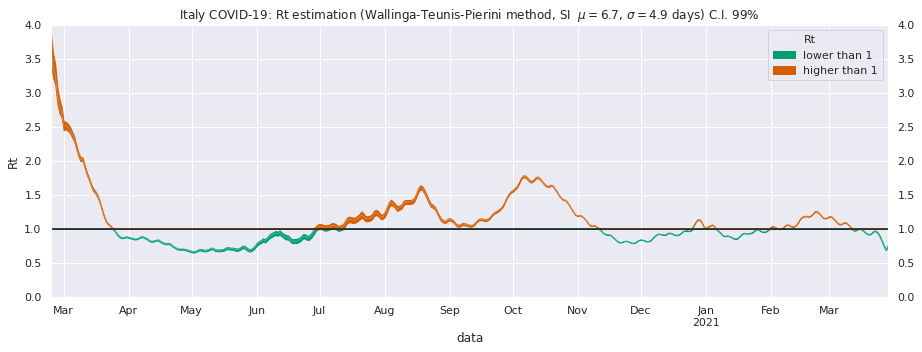

In [27]:
smry = plot_Rt(pyjags_data,
            it.index[:-1],
            it.index[0],
            SI_mu, SI_sd,
            title='Italy')

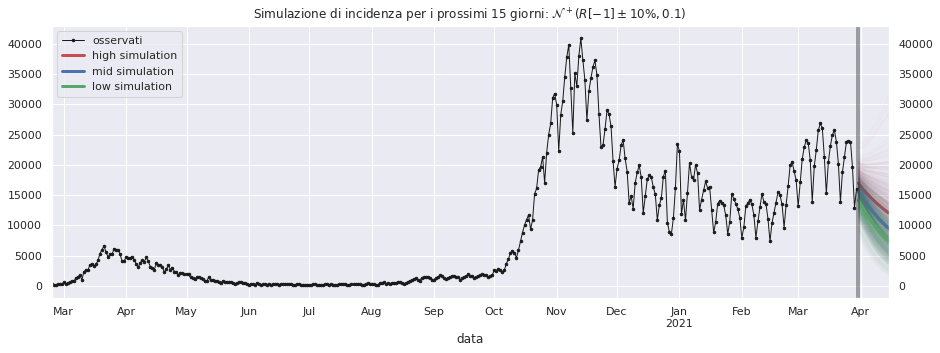

In [28]:
plot_simulations(pyjags_data, back=it.index.size, df=it, prediction=prediction, sample=sample)

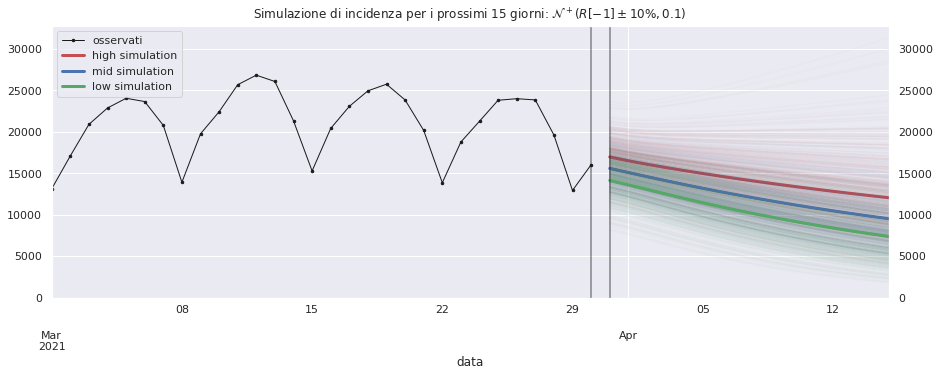

In [29]:
plot_simulations(pyjags_data, back=30, df=it, prediction=prediction, sample=sample)

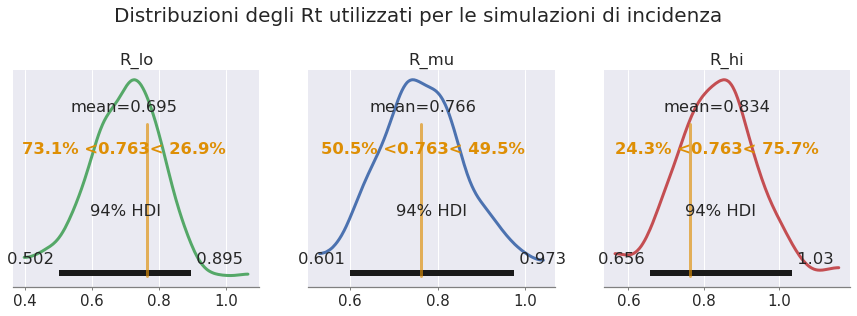

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

az.plot_posterior(
    pyjags_data.posterior.R_lo[:,:], ref_val=smry['mean'].iloc[-1], ax=ax[0],
    color='g', lw=3, round_to=3, textsize=15
)
az.plot_posterior(
    pyjags_data.posterior.R_mu[:,:], ref_val=smry['mean'].iloc[-1], ax=ax[1],
    color='b', lw=3, round_to=3, textsize=15
)
az.plot_posterior(
    pyjags_data.posterior.R_hi[:,:], ref_val=smry['mean'].iloc[-1], ax=ax[2],
    color='r', lw=3, round_to=3, textsize=15
)

fig.suptitle('Distribuzioni degli Rt utilizzati per le simulazioni di incidenza', y=1.1, fontsize=20)
plt.show()

In [31]:
Rt_italy_json = {
    'mean': smry['mean'].iloc[-1],
    'max': smry['hdi_99.5%'].iloc[-1],
    'min': smry['hdi_0.5%'].iloc[-1]
}
with open('Rt_italy.json', 'w') as f:
    json.dump(Rt_italy_json, f)

# REGIONS

In [32]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [33]:
rg = covid_regioni()

In [34]:
def pierini_Rt(df, column, ignore=5,
               SI_sh=None, SI_ra=None, 
               conf_int=.99, smooth=7,
               #resample='last-day-of-week',
               func=np.mean, samples=100,
               plot_latest_Rt=False,
               plot=False, title='', ylim=(0, 5)):
    
    """
    Estimate Istantaneous Reproduction Number Rt with
    given observed incidence and serial interval ditribution
    parameters (shape and rate of Gamma distribution).
    Results are resampled given the chosen method
    (default: by week, starting from last day) and function
    (default: mean).
    
    Args:
    ----------------------------------------------------------------
    df       : (dataframe) : dataframe of observed incidence [1]
    column   : (string)    : column of incidence in dataframe
    SI_sh    : (float)     : serial interval distribution shape [2]
    SI_ra    : (float)     : serial interval distribution rate [2]
    conf_int : (float)     : wanted confidence interval
    resample : (string)    : resample string [3]
    func     : (function)  : resample function [4]
    plot     : (boolean)   : plot results or not
    
    Returns:
    ----------------------------------------------------------------
    A pandas dataframe with estimated Rt and confidence intervals.
    
    Notes:
    ----------------------------------------------------------------
    [1] the dataframe should contain at least a column with observed
        incidence and index should refer to observations datetime
    [2] if no shape/rate are defined, a default one will be assigned
    [3] see pandas documentation for resample offset strings
    [4] default is np.mean
    """

    _lo = (1 - conf_int) / 2 * 100
    _hi = 100 - _lo
    
    df = df.copy(deep=True)
    T = df.index.size
    
    Rt0 = sps.halfnorm(0, 0.1).rvs(samples)
    
    less_than_zero = df[column]<0
    if less_than_zero.sum():
        print('Warning: negative values in incidence. Adjusting...')
        df.loc[less_than_zero, column] = 0

    if SI_sh is None or SI_ra is None:
        print('Warning: no serial interval given.')
        print('Assigning default one...')
        SI_sh = 1.87
        SI_ra = 0.28
    
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x = np.arange(1, T+1, 1)
    SI_y = SI_dist.pdf(SI_x)

    pois_vars = np.zeros(shape=(T, samples))
    for t in range(T):
        pois_var = sps.poisson.rvs(df[column].values[t], size=samples)
        pois_vars[t,:] = pois_var

    Rt = np.zeros(shape=(T, samples))
    for t in range(T):
        if t < 1:
            continue
        if np.any(pois_vars[t] < ignore):
            Rt[t,:] = Rt0
            continue
        last = pois_vars[t]
        old = (pois_vars[:t] * SI_y[:t][::-1][:,None]).sum(axis=0)
        if np.any(old < ignore):
            Rt[t,:] = Rt0
            continue

        R_rvs = last / old
        Rt[t,:] = R_rvs
        
    Rt[0,:] = Rt[1:8].mean(axis=0)
    R = pd.DataFrame(columns=['R', 'sd', 'lo', 'hi'])
    R['R'] = np.median(Rt, axis=1)
    R['sd'] = np.std(Rt, axis=1)
    R['lo'], R['hi'] = np.percentile(Rt, [_lo, _hi], axis=1)
    R.index = df.index
    
    R_smoothed = R.rolling(smooth).mean()
    R_smoothed = R_smoothed[(smooth-1):]
    R_smo_len = R_smoothed.index.size
    idx_min = smooth // 2
    idx_max = R_smo_len + idx_min
    R_smoothed.index = R.index[idx_min:idx_max]
    
    latest_sh = R_smoothed.R[-1]**2 / R_smoothed.sd[-1]**2
    latest_ra = R_smoothed.R[-1] / R_smoothed.sd[-1]**2
    latest_Rd = sps.gamma(a=latest_sh, scale=1/latest_ra)
    latest_Rs = latest_Rd.rvs(size=10000)
    latest_Rx = np.linspace(latest_Rd.ppf(_lo/100), latest_Rd.ppf(_hi/100), 100)
    latest_Ry = latest_Rd.pdf(latest_Rx)
    latest_Rm = latest_Rd.mean()
    if latest_Rm > 1:
        p_val = latest_Rd.cdf(1)
    else:
        p_val = 1 - latest_Rd.cdf(1)
    
    if plot:
        ax = R_smoothed.plot(
            figsize=(12, 5), y='R', color='k',
            lw=1,
        )
        ax.fill_between(
            R_smoothed.index,
            R_smoothed.lo, R_smoothed.hi,
            color='k', alpha=.25,
            label=f'C.I. {conf_int:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ax.legend()
        ax.set(
            title=f'{title} Rt estimation (Method: JARE-Pierini 2020)',
            ylabel='R(t)', xlabel='date',
            ylim=ylim
        )
        plt.show()
        
    if plot_latest_Rt:
        ax = az.plot_posterior(
            latest_Rs, ref_val=1,
            figsize=(8, 3),
            round_to=5,
            hdi_prob=conf_int,
            textsize=15
        )
        ax.text(
            .05, 1.1,
            f'$p$-val = {p_val:.3f}',
            fontsize=10, color='k',
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(.2, .2, .2),
                   fc=(.9, .9, .9, .5),
                   ),
            transform=ax.transAxes
        )
        ax.set(
            title=f'{title} Latest Rt {R_smoothed.index[-1].date()} (Method: JARE-Pierini 2020)'
        )
        plt.show()
    
    return R_smoothed, latest_Rs

## Abruzzo

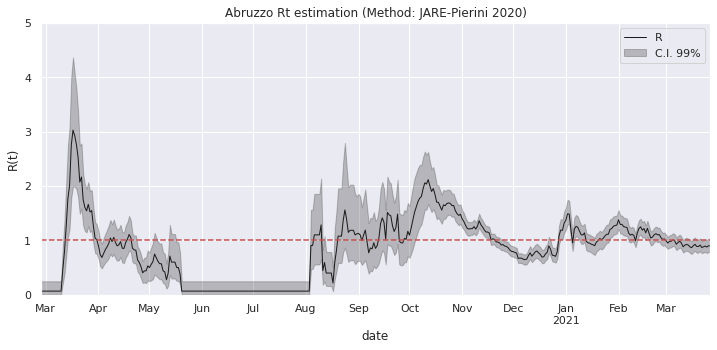

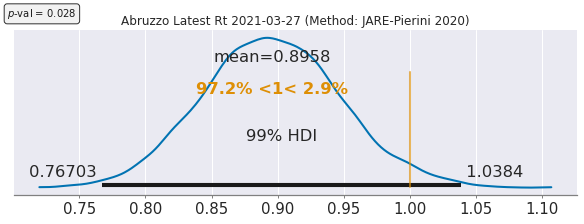

## Basilicata

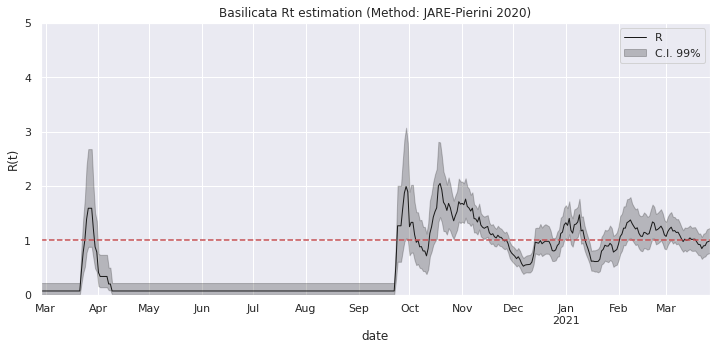

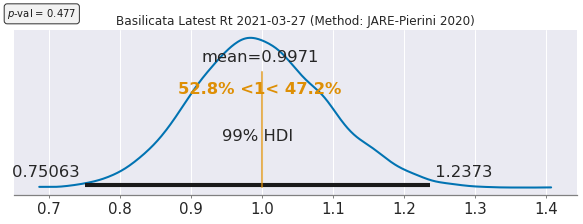

## Calabria

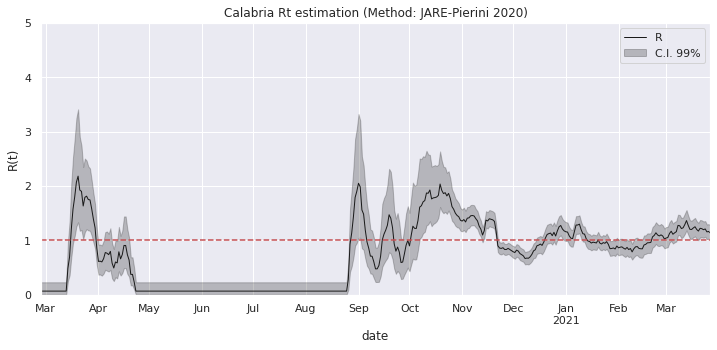

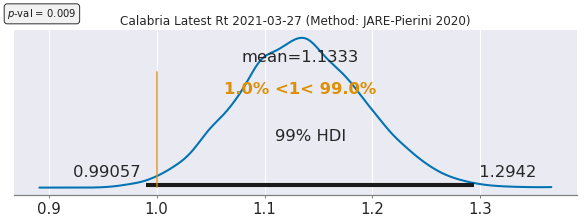

## Campania

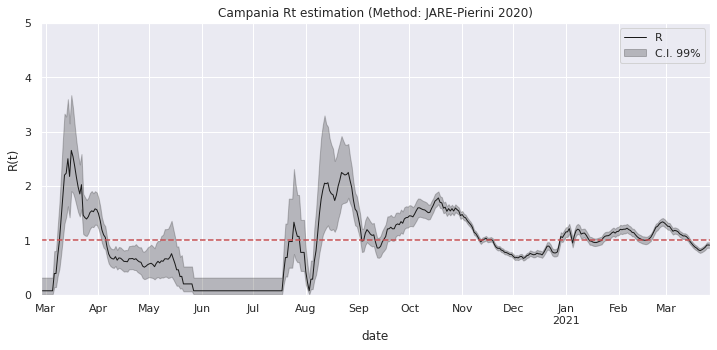

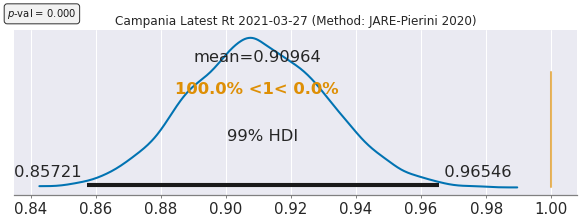

## Emilia-Romagna

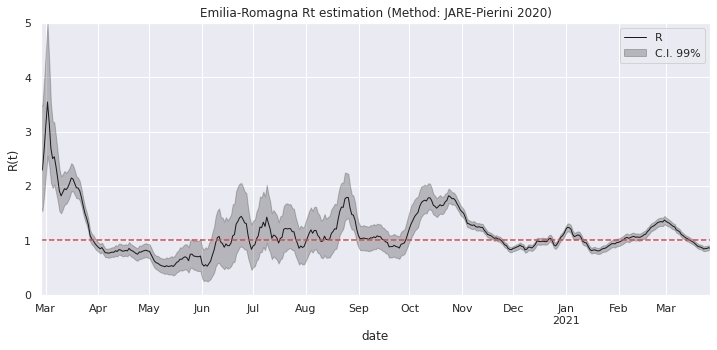

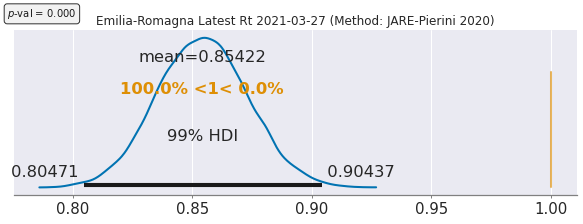

## Friuli Venezia Giulia

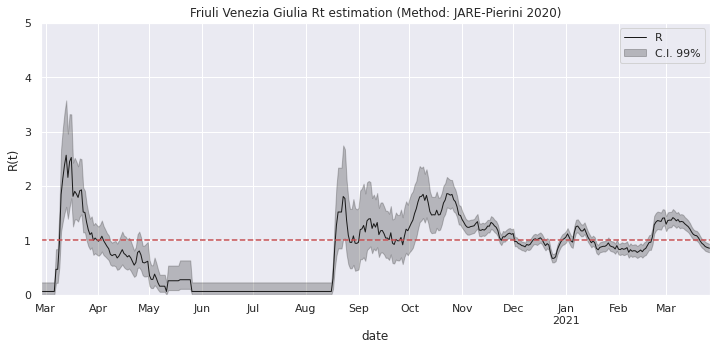

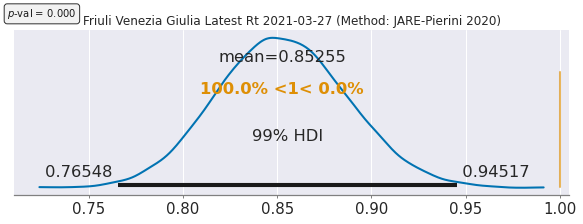

## Lazio

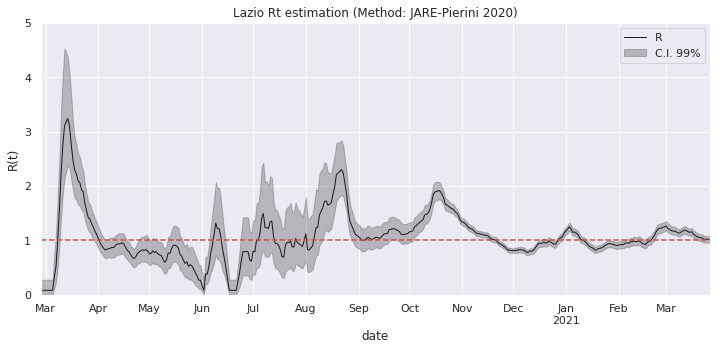

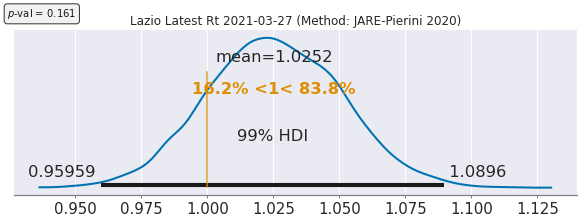

## Liguria

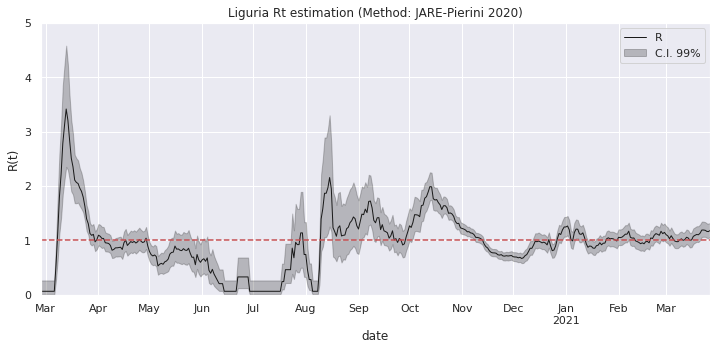

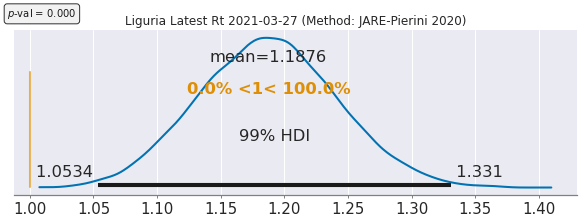

## Lombardia

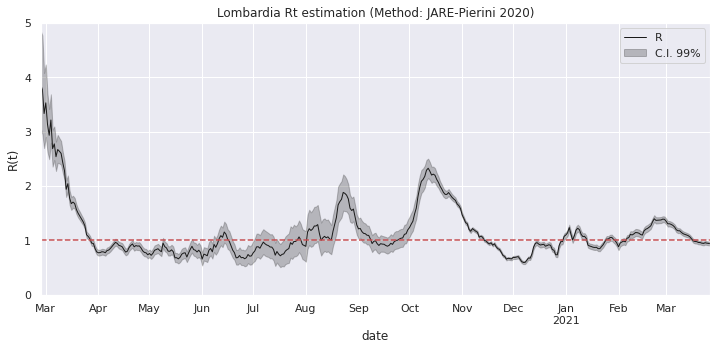

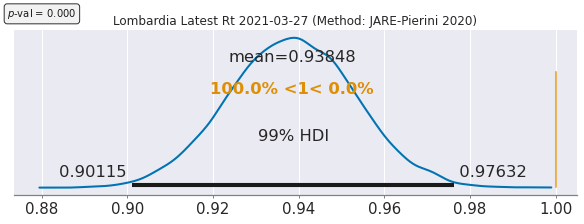

## Marche

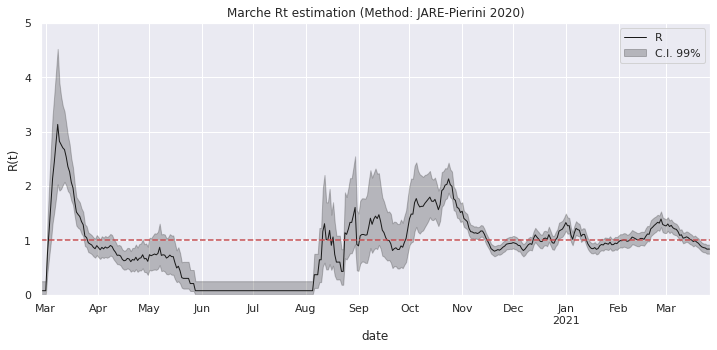

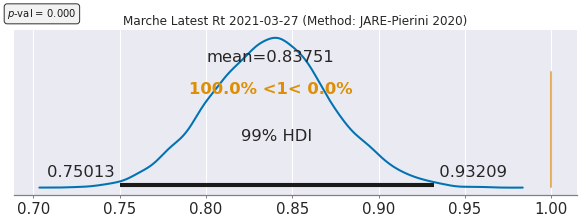

## Molise

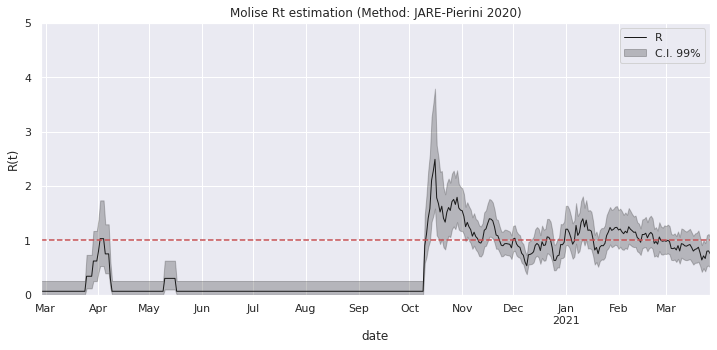

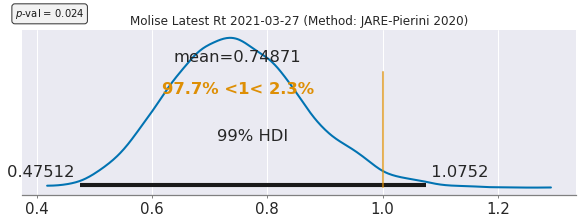

## P.A. Bolzano

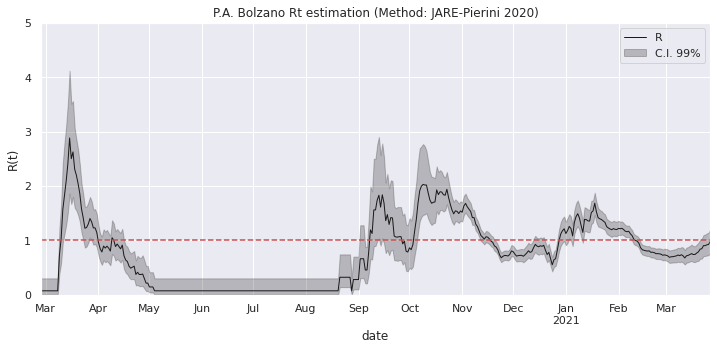

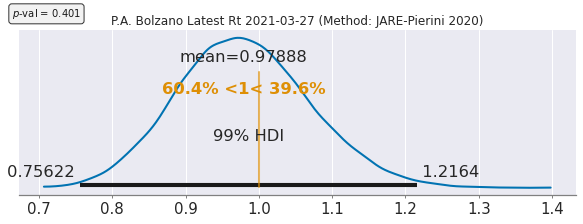

## P.A. Trento

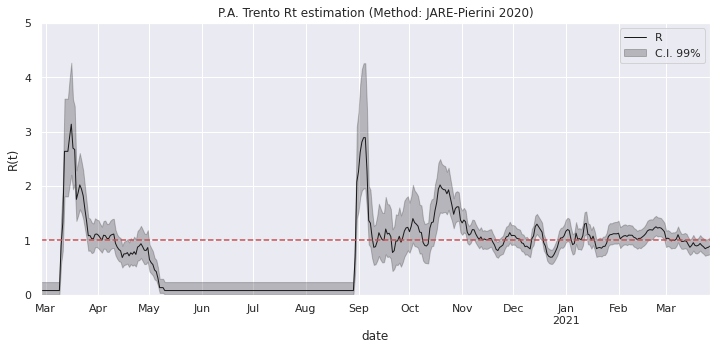

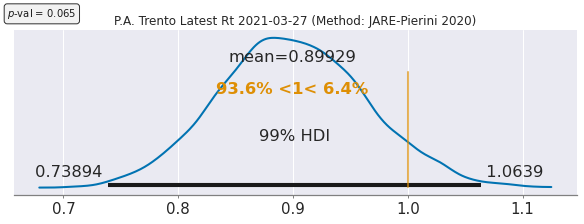

## Piemonte

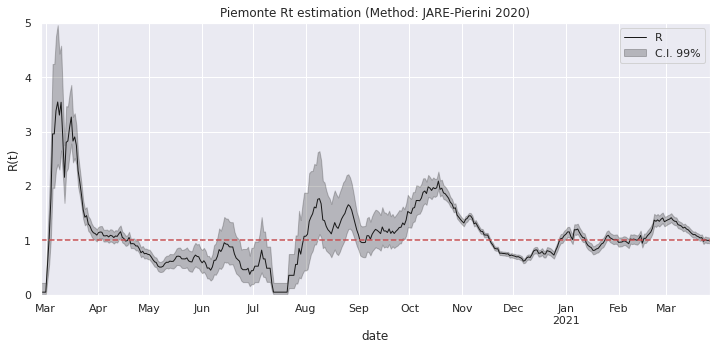

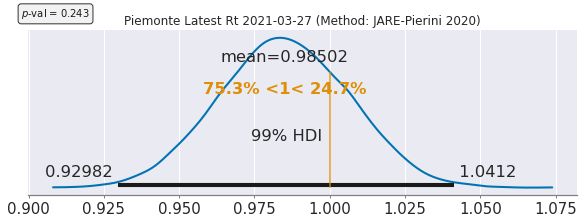

## Puglia

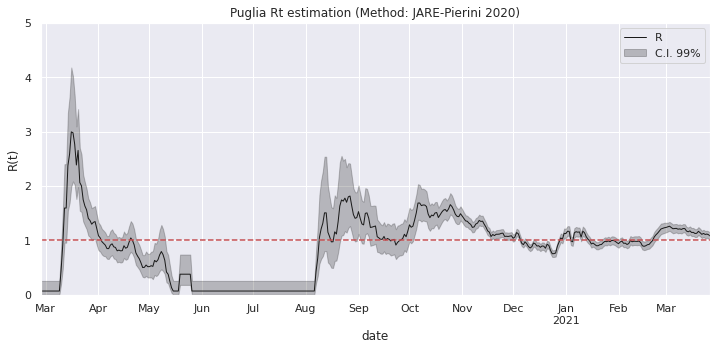

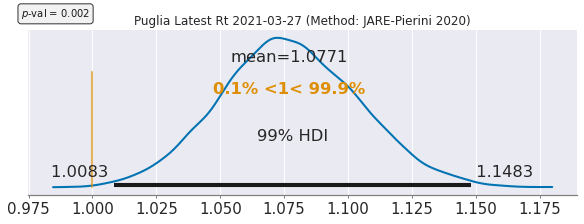

## Sardegna

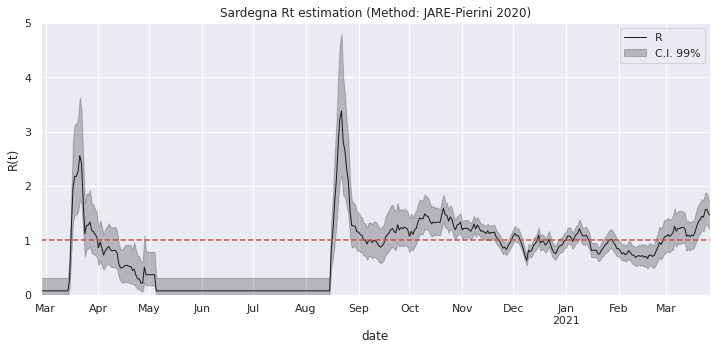

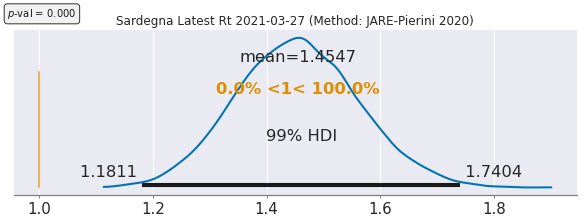

## Sicilia

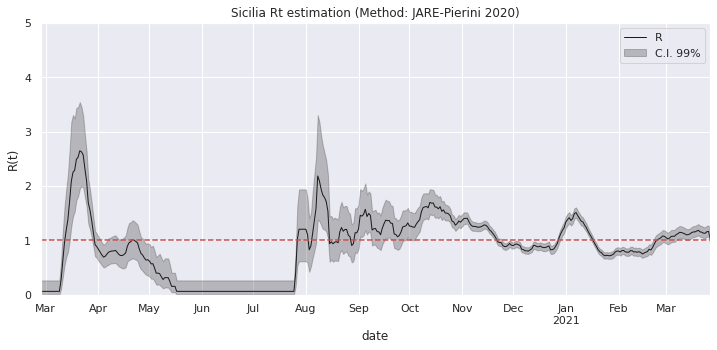

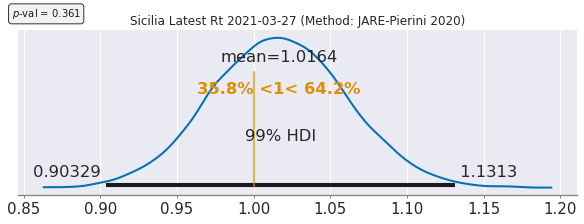

## Toscana

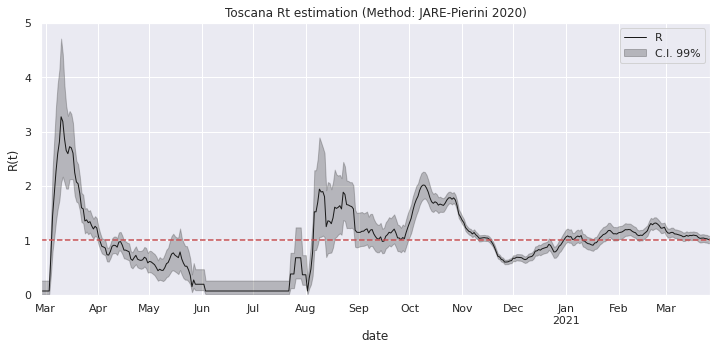

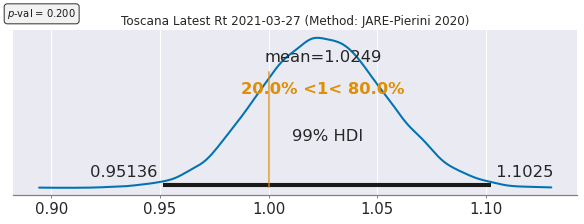

## Umbria

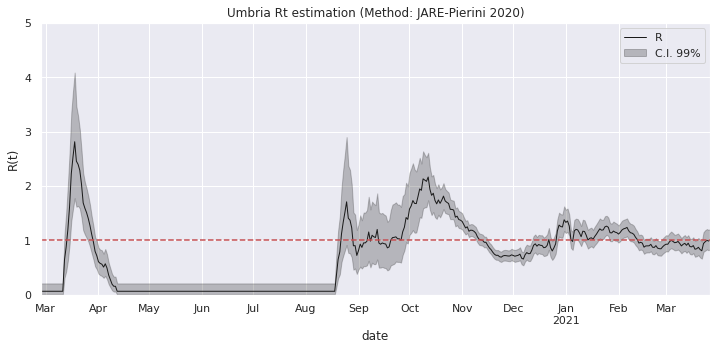

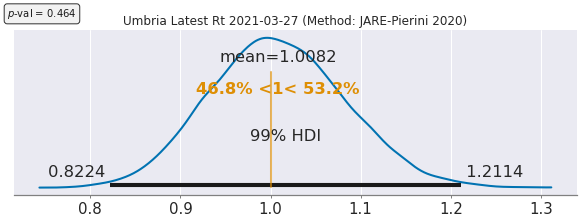

## Valle d'Aosta

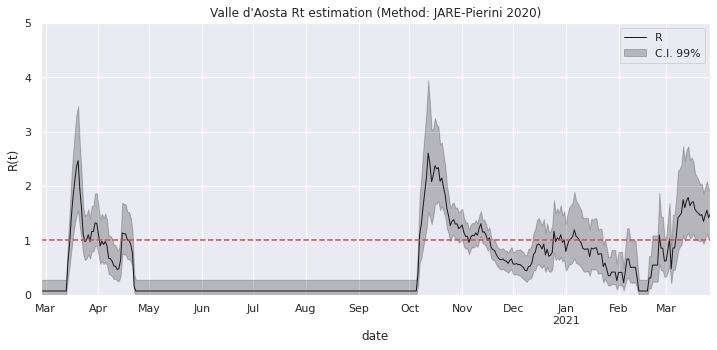

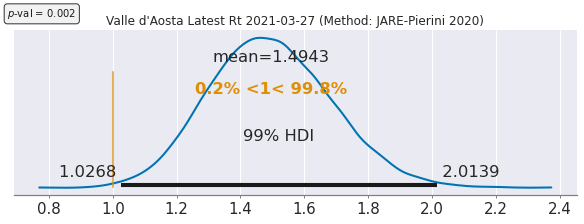

## Veneto

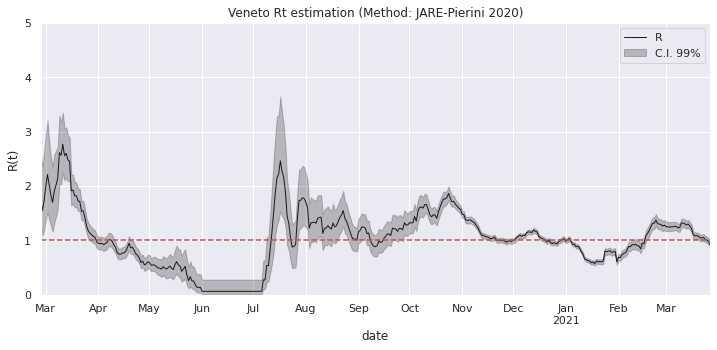

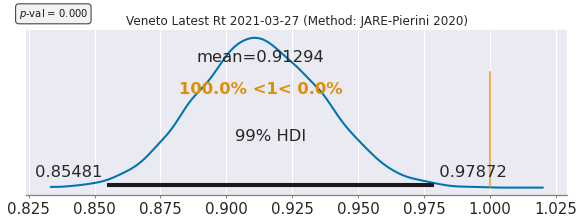

In [35]:
Rt_regioni_json = {}
Rt_latest_regions = {'region': [], 'lo': [], 'mu': [], 'hi': []}

for regione in rg.denominazione_regione.unique():
    
    display(Markdown(f"## {regione}"))

    _df = rg[rg.denominazione_regione==regione].copy(deep=True)
    T = _df.index.size
    _df.loc[_df.nuovi_positivi<0, 'nuovi_positivi'] = 0
    
    R, Rs = pierini_Rt(_df, 'nuovi_positivi', 
                   SI_sh=ISS_sh, SI_ra=ISS_ra,
                   smooth=7, samples=100, ignore=5, 
                   plot=True, plot_latest_Rt=True, title=regione)
    
    Rt_latest_regions['region'].append(regione)
    Rt_latest_regions['mu'].append(R['R'].iloc[-7:].mean())
    Rt_latest_regions['lo'].append(R['lo'].iloc[-7:].min())
    Rt_latest_regions['hi'].append(R['hi'].iloc[-7:].max())
    
    Rt_regioni_json.update({regione: R['R'].iloc[-1]})
    
with open('Rt_regioni.json', 'w') as f:
    json.dump(Rt_regioni_json, f)

# SUMMARY

In [36]:
Rt_latest_regions_df = pd.DataFrame(Rt_latest_regions)

In [37]:
for regione in Rt_latest_regions_df.region.unique():
    _r = Rt_latest_regions_df[Rt_latest_regions_df.region==regione]
    stato = '~ 1'
    if _r.hi.unique()[0] < 1:
        stato = '< 1'
    elif _r.lo.unique()[0] > 1:
        stato = '> 1'
    Rt_latest_regions_df.loc[Rt_latest_regions_df.region==regione, 'stato'] = stato

In [38]:
Rt_melt_reg = Rt_latest_regions_df.melt(id_vars=['region', 'stato'])

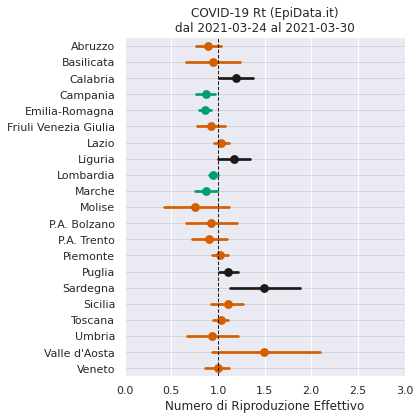

In [39]:
ax = sns.catplot(
    data=Rt_melt_reg,
    kind='point',
    x='value', y='region',
    join=False,
    hue='stato',
    hue_order=['< 1', '~ 1', '> 1'],
    #palette=['C2', 'C1', 'C0'],
    palette=['C2', 'C3', 'k'],
    aspect=1, height=6,
    ci=100, legend=False
)

try:
    ax.axes.flat[0].axvline(1, color='k', ls='--', lw=1)

    ax.axes.flat[0].set(
        xlim=(0, np.ceil(np.max(Rt_latest_regions_df.hi))),
        ylabel='',
        xlabel='Numero di Riproduzione Effettivo',
        title=f'COVID-19 Rt (EpiData.it)\ndal {rg.index.unique()[-7].date()} al {rg.index.unique()[-1].date()}'
    )
except Exception as err:
    print(err)
ax.axes.flat[0].grid(axis='y', color='k', alpha=.1)
ax.fig.tight_layout()
ax.fig.savefig('regioni_rt.png')
plt.show()

***

In [40]:
end = dt.datetime.now()
print(f"END: {end}")
print(f"Completed in {end - start}")

END: 2021-03-30 19:59:48.976479
Completed in 0:01:05.148074
